In [1]:
import nemo
import nemo.collections.nlp as nemo_nlp
from nemo.collections.nlp.data.datasets import BertTextClassificationDataset
from nemo.collections.nlp.nm.data_layers.text_classification_datalayer import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import SequenceClassifier

from nemo.backends.pytorch.common import CrossEntropyLossNM
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import torch

/home/ebakhturina/nvidia/NeMo/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')


## Data Explore

The SST-2 dataset https://nlp.stanford.edu/sentiment/index.html is a standard benchmark for sentence classification and is part of the GLUE Benchmark: https://gluebenchmark.com/tasks. Please download and unzip the SST-2 dataset from GLUE.

In [2]:
WORK_DIR = 'logs'
DATA_DIR = 'data/SST-2'

# To use mixed precision, set AMP_OPTIMIZATION_LEVEL to 'O1' or 'O2',
# to train without mixed precision, set it to 'O0'.
AMP_OPTIMIZATION_LEVEL = 'O1'
PRETRAINED_BERT_MODEL = 'bert-base-uncased'
MAX_SEQ_LEN = 64 # we will pad with 0's shorter sentences and truncate longer
BATCH_SIZE = 256 # 64 for 'bert-large-uncased'

In [4]:
df = pd.read_csv(DATA_DIR + '/train.tsv', sep='\t')
test_df = pd.read_csv(DATA_DIR + '/test.tsv', sep='\t')

In [5]:
df.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


In [6]:
test_df.head()

,index,sentence
0,0,uneasy mishmash of styles and genres .
1,1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .
2,2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ."
3,3,director rob marshall went out gunning to make a great one .
4,4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new ."


The dataset comes with a train file (labeled) and a test file (not labeled).  We will use part of the train file for model validation

In [7]:
# Split train to train and val and save to disk
np.random.seed(123)
train_mask = np.random.rand((len(df))) < .8
train_df = df[train_mask]
val_df = df[~train_mask]

In order to take advantage of NeMo's pre-built sentence classification data layer, the data should be formatted as "sentence\tlabel" (sentence tab label).

In [8]:
# We will add a label column with all 0's (but they will not be used for anything).
test_df['label'] = 0

In [9]:
test_df = test_df[['sentence', 'label']]

In [10]:
test_df.head()

,sentence,label
0,uneasy mishmash of styles and genres .,0
1,this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation .,0
2,"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .",0
3,director rob marshall went out gunning to make a great one .,0
4,"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new .",0


In [11]:
# Save new train, val, and test to disk
SPLIT_DATA_DIR = os.path.join(DATA_DIR, 'split')

os.makedirs(SPLIT_DATA_DIR, exist_ok=True)

train_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'train.tsv'), sep='\t', index=False)
val_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'eval.tsv'), sep='\t', index=False)
test_df.to_csv(os.path.join(SPLIT_DATA_DIR, 'test.tsv'), sep='\t', index=False)

## Neural Modules

In NeMo, everything is a Neural Module. Neural modules abstract data and neural network architectures. Where a deep learning framework like PyTorch or Tensorflow is used to combine neural network layers to create a neural network. 
NeMo is used to combine data and neural networks to create AI applications.
The Neural Module Factory will then manage the neural modules, taking care to flow data through the neural modules, and is also responsible for training (including mixed precision and distributed), logging, and inference.

In [12]:
# instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level=AMP_OPTIMIZATION_LEVEL)

[NeMo I 2020-02-28 15:33:48 exp_logging:185] Not using TensorBoard.
[NeMo I 2020-02-28 15:33:48 exp_logging:186] Install tensorboardX to use TensorBoard


[NeMo W 2020-02-28 15:33:48 deprecated:68] Function ``_get_trainer`` is deprecated. It is going to be removed in the future version.


Pre-trained models will be automatically downloaded and cached.

In [13]:
# Pre-trained BERT
bert = nemo_nlp.nm.trainables.huggingface.BERT(pretrained_model_name=PRETRAINED_BERT_MODEL)
tokenizer = nemo_nlp.data.NemoBertTokenizer(PRETRAINED_BERT_MODEL)

Note here that the BERT models we are working with are massive. This gives our models a large capacity for learning that is needed to understand the nuance and complexity of natural language.

In [14]:
print(f'{PRETRAINED_BERT_MODEL} has {bert.num_weights} weights')

bert-base-uncased has 109482240 weights


Here we define and instantiate the feed forward network that takes as input our BERT embeddings. This network will be used to output the sentence classifications.

In [15]:
# mlp classifier
bert_hidden_size = bert.local_parameters['hidden_size']

mlp = SequenceClassifier(hidden_size=bert_hidden_size, 
                         num_classes=2,
                         num_layers=2,
                         log_softmax=False,
                         dropout=0.1)

loss = CrossEntropyLossNM()

[NeMo W 2020-02-28 15:33:55 deprecated:68] Function ``local_parameters`` is deprecated. It is going to be removed in the 0.11 version.
/home/ebakhturina/anaconda3/lib/python3.7/site-packages/torch-1.2.0-py3.7-linux-x86_64.egg/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [16]:
# Compared to the BERT model, the MLP is tiny.
print(f'MLP has {mlp.num_weights} weights')

MLP has 592130 weights


# Pipelines

Pipelines are used to define how data will flow the different neural networks. In this case, our data will flow through the BERT network and then the MLP network.

We also have different pipelines for training, validation, and inference data.  

For training data, we want it to be used for optimization so it must be shuffled and we also need to compute the loss.

For validation data, we won't use it for optimization but we want to know the loss.

And for inference data, we only want the final predictions coming from the model.

## Data Layers

We can gain a lot of efficiency by saving the tokenized data to disk. For future model runs we then don't need to tokenize every time.

In [17]:
USE_CACHE = True

train_data = BertTextClassificationDataLayer(input_file=os.path.join(SPLIT_DATA_DIR, 'train.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE,
                                             model_name=PRETRAINED_BERT_MODEL)

val_data = BertTextClassificationDataLayer(input_file=os.path.join(SPLIT_DATA_DIR, 'eval.tsv'),
                                           tokenizer=tokenizer,
                                           max_seq_length=MAX_SEQ_LEN,
                                           batch_size=BATCH_SIZE,
                                           use_cache=USE_CACHE,
                                           model_name=PRETRAINED_BERT_MODEL)

[NeMo I 2020-02-28 15:33:57 text_classification_dataset:213] features restored from /home/ebakhturina/data/GLUE_DATA/glue_data/SST-2/split/bert-base-uncased_train_features.hdf5
[NeMo I 2020-02-28 15:33:57 text_classification_dataset:213] features restored from /home/ebakhturina/data/GLUE_DATA/glue_data/SST-2/split/bert-base-uncased_eval_features.hdf5


In [18]:
train_input, train_token_types, train_attn_mask, train_labels = train_data()
val_input, val_token_types, val_attn_mask, val_labels = val_data()

## BERT Embeddings

In [19]:
train_embeddings = bert(input_ids=train_input,
                        token_type_ids=train_token_types,
                        attention_mask=train_attn_mask)
val_embeddings = bert(input_ids=val_input,
                      token_type_ids=val_token_types,
                      attention_mask=val_attn_mask)

## Inspect BERT Embeddings

If we want to inspect the data as it flows through our neural factory we can use the .infer method.  This method will give us the tensors without performing any optimization.

In [20]:
val_input_tensors = nf.infer(tensors=[val_input])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-02-28 15:37:51 actions:729] Evaluating batch 0 out of 53
[NeMo I 2020-02-28 15:37:51 actions:729] Evaluating batch 5 out of 53
[NeMo I 2020-02-28 15:37:51 actions:729] Evaluating batch 10 out of 53
[NeMo I 2020-02-28 15:37:52 actions:729] Evaluating batch 15 out of 53
[NeMo I 2020-02-28 15:37:52 act

In [21]:
print(val_input_tensors[0][0][0])

tensor([  101, 16691,  2008,  1996,  2472,  1997,  2107,  5365, 27858,  2015,
         2004, 16419,  2399,  2064,  2145,  2735,  2041,  1037,  2235,  1010,
         3167,  2143,  2007,  2019,  6832,  2813,  7361,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [22]:
%%time
val_embeddings_tensors = nf.infer(tensors=[val_embeddings])

[NeMo I 2020-02-28 15:37:54 actions:729] Evaluating batch 0 out of 53
[NeMo I 2020-02-28 15:37:55 actions:729] Evaluating batch 5 out of 53
[NeMo I 2020-02-28 15:37:56 actions:729] Evaluating batch 10 out of 53
[NeMo I 2020-02-28 15:37:57 actions:729] Evaluating batch 15 out of 53
[NeMo I 2020-02-28 15:37:58 actions:729] Evaluating batch 20 out of 53
[NeMo I 2020-02-28 15:37:59 actions:729] Evaluating batch 25 out of 53
[NeMo I 2020-02-28 15:37:59 actions:729] Evaluating batch 30 out of 53
[NeMo I 2020-02-28 15:38:00 actions:729] Evaluating batch 35 out of 53
[NeMo I 2020-02-28 15:38:01 actions:729] Evaluating batch 40 out of 53
[NeMo I 2020-02-28 15:38:02 actions:729] Evaluating batch 45 out of 53
[NeMo I 2020-02-28 15:38:03 actions:729] Evaluating batch 50 out of 53
CPU times: user 6.29 s, sys: 3.65 s, total: 9.94 s
Wall time: 10.7 s


In [23]:
# each word is embedded into bert_hidden_size space
# shape: BATCH_SIZE * MAX_SEQ_LEN * bert_hidden_size
val_embeddings_tensors[0][0].shape

torch.Size([256, 64, 768])

In [24]:
print(val_embeddings_tensors[0][0][1][:, 0])

tensor([-0.0413,  0.3514, -0.0905,  0.4339,  0.1867, -0.1051,  0.1173,  1.0779,
         1.6062,  0.7324, -0.0286,  0.3876, -0.1485,  0.2844,  0.1237,  0.3313,
        -0.0739,  0.9673,  0.6246,  1.8734,  0.2032, -0.8772,  1.2982,  0.1376,
         0.1291,  0.8683,  0.6114,  0.6802,  0.8892,  0.3687,  0.5617,  0.3339,
         0.6599,  0.5201,  0.2775,  0.2692,  0.2923,  0.5701,  0.6468,  0.6732,
         0.3353, -0.0224, -0.0822,  0.2347,  0.0615,  0.3281,  0.3373,  0.3231,
         0.0716, -0.1939,  0.4174, -0.0328,  0.1763,  0.5045,  0.0906,  0.5959,
         0.7836,  0.8570,  0.3596,  0.2215,  0.2626,  0.1899,  0.2107,  0.4543])


## Understanding and Visualizing BERT Embeddings

We are going to look at the BERT embeddings for the words (1-word sentences) in "SPLIT_DATA_DIR/positive_negative.tsv". Since the BERT embeddings are 768 dimensional for BERT base and 1024 dimensional for BERT large, we'll first apply TSNE and reduce the embeddings to two dimensions.

In [25]:
spectrum_words = ['abysmal', 'apalling', 'dreadful', 'awful', 'terrible',
                  'very bad', 'really bad', 'rubbish', 'unsatisfactory',
                  'bad', 'poor', 'great', 'really good', 'very good', 'awesome'
                  'fantastic', 'superb', 'brilliant', 'incredible', 'excellent'
                  'outstanding', 'perfect']

spectrum_file = os.path.join(SPLIT_DATA_DIR, 'positive_negative.tsv')
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')

In [26]:
spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')
print(spectrum_df.head())

   sentence  label
0  abysmal   0    
1  apalling  0    
2  dreadful  0    
3  awful     0    
4  terrible  0    


In [27]:
# positive negative spectrum
spectrum_data = BertTextClassificationDataLayer(input_file=spectrum_file,
                                                tokenizer=tokenizer,
                                                max_seq_length=MAX_SEQ_LEN,
                                                batch_size=BATCH_SIZE,
                                                model_name=PRETRAINED_BERT_MODEL)

[NeMo I 2020-02-28 15:38:03 text_classification_dataset:78] /home/ebakhturina/data/GLUE_DATA/glue_data/SST-2/split/positive_negative.tsv: 20
[NeMo I 2020-02-28 15:38:03 data_preprocessing:245] Min: 3 |                  Max: 6 |                  Mean: 3.85 |                  Median: 3.0
[NeMo I 2020-02-28 15:38:03 data_preprocessing:247] 75 percentile: 4.25
[NeMo I 2020-02-28 15:38:03 data_preprocessing:248] 99 percentile: 6.0
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:114] 0 out of 20                         sentences with more than 64 subtokens.
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:171] *** Example ***
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:172] example_index: 0
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:173] subtokens: [CLS] ab ##ys ##mal [SEP]
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:174] sent_label: 0
[NeMo I 2020-02-28 15:38:03 text_classification_dataset:175] input_ids: 101 11113 7274 9067 102 0 0 0 0 0 

In [28]:
spectrum_input, spectrum_token_types, spectrum_attn_mask, spectrum_labels = spectrum_data()

In [29]:
spectrum_embeddings = bert(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)

In [30]:
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

[NeMo I 2020-02-28 15:38:05 actions:729] Evaluating batch 0 out of 1


In [31]:
spectrum_embeddings_tensors[0][0].shape

torch.Size([20, 64, 768])

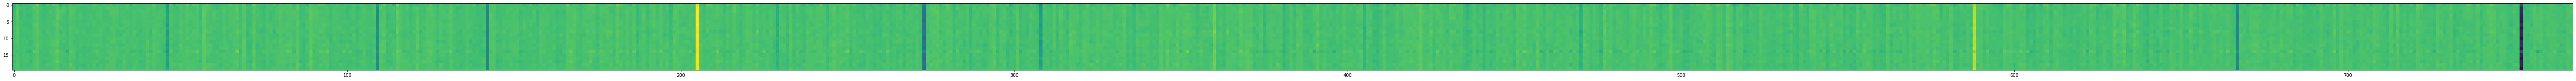

In [32]:
plt.figure(figsize=(100,100))
plt.imshow(spectrum_embeddings_tensors[0][0][:,0,:].numpy())

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 2.212460
[t-SNE] KL divergence after 100 iterations with early exaggeration: 35.232384
[t-SNE] KL divergence after 650 iterations: 0.116021


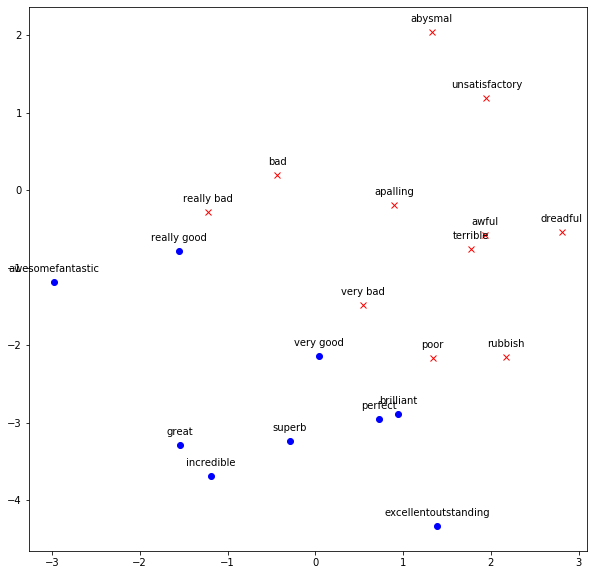

In [33]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Training Pipeline 

In order to optimize our network, we need to pass the embeddings through the MLP network and then compute the loss.

In [34]:
train_logits = mlp(hidden_states=train_embeddings)
val_logits = mlp(hidden_states=val_embeddings)

train_loss = loss(logits=train_logits, labels=train_labels)
val_loss = loss(logits=val_logits, labels=val_labels)

## Callbacks

Callbacks are used to record and log metrics and save checkpoints for the training and evaluation. We use callbacks to print to screen and also to tensorboard.




In [35]:
NUM_EPOCHS = 3
NUM_GPUS = 1
LEARNING_RATE = 5e-5
OPTIMIZER = 'adam'

train_data_size = len(train_data)
steps_per_epoch = math.ceil(train_data_size / (BATCH_SIZE * NUM_GPUS))

train_callback = nemo.core.SimpleLossLoggerCallback(tensors=[train_loss, train_logits],
                            print_func=lambda x:nemo.logging.info(f'Train loss: {str(np.round(x[0].item(), 3))}'),
                            tb_writer=nf.tb_writer,
                            get_tb_values=lambda x: [["train_loss", x[0]]],
                            step_freq=steps_per_epoch)

eval_callback = nemo.core.EvaluatorCallback(eval_tensors=[val_logits, val_labels],
                                            user_iter_callback=lambda x, y: eval_iter_callback(x, y, val_data),
                                            user_epochs_done_callback=lambda x:
                                                eval_epochs_done_callback(x, f'{nf.work_dir}/graphs'),
                                            tb_writer=nf.tb_writer,
                                            eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = nemo.core.CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

In [36]:
lr_policy_fn = get_lr_policy('WarmupAnnealing',
                             total_steps=NUM_EPOCHS * steps_per_epoch,
                             warmup_ratio=0.1)

In [37]:
%%time
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer=OPTIMIZER,
         optimization_params={'num_epochs': NUM_EPOCHS, 'lr': LEARNING_RATE})

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-02-28 15:38:08 callbacks:179] Starting .....
[NeMo I 2020-02-28 15:38:08 callbacks:349] Found 2 modules with weights:
[NeMo I 2020-02-28 15:38:08 callbacks:351] SequenceClassifier
[NeMo I 2020-02-28 15:38:08 callbacks:351] BERT
[NeMo I 2020-02-28 15:38:08 callbacks:352] Total model parameters: 11007

[NeMo W 2020-02-28 15:38:08 callbacks:318] For module SequenceClassifier, no file matches  in logs/checkpoints
[NeMo W 2020-02-28 15:38:08 callbacks:320] Checkpoint folder logs/checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2020-02-28 15:38:08 callbacks:190] Starting epoch 0
[NeMo I 2020-02-28 15:38:10 callbacks:214] Step: 0
[NeMo I 2020-02-28 15:38:10 <ipython-input-35-7152641ca2af>:10] Train loss: 0.695
[NeMo I 2020-02-28 15:38:10 callbacks:229] Step time: 0.4613332748413086 seconds
[NeMo I 2020-02-28 15:38:10 callbacks:428] Doing Evaluation ..............................


Exception ignored in: <function _releaseLock at 0x7fcf4257def0>
Traceback (most recent call last):
  File "/home/ebakhturina/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: 

## Multi-Gpu Training

RESTART KERNEL BEFORE RUNNING THE MULTI-GPU TRAINING

In [ ]:
%%time
num_gpus = 4
!python -m torch.distributed.launch --nproc_per_node=$NUM_GPUS text_classification_with_bert.py \
--pretrained_model_name $PRETRAINED_BERT_MODEL \
--data_dir $SPLIT_DATA_DIR \
--dataset_name 'sst-2' \
--train_file_prefix 'train' \
--eval_file_prefix 'eval' \
--use_cache \
--batch_size 64 \
--max_seq_length 64 \
--num_gpus $NUM_GPUS \
--num_epochs $NUM_EPOCHS \
--amp_opt_level $AMP_OPTIMIZATION_LEVEL \
--work_dir $WORK_DIR

## Inference Pipeline

For inference we instantiate the same neural modules but now we will be using the checkpoints that we just learned.

In [ ]:
test_data = BertTextClassificationDataLayer(input_file=os.path.join(SPLIT_DATA_DIR, 'test.tsv'),
                                            tokenizer=tokenizer,
                                            max_seq_length=MAX_SEQ_LEN,
                                            batch_size=BATCH_SIZE,
                                            model_name=PRETRAINED_BERT_MODEL)

In [ ]:
test_input, test_token_types, test_attn_mask, _ = test_data()
test_embeddings = bert(input_ids=test_input,
                        token_type_ids=test_token_types,
                        attention_mask=test_attn_mask)
test_logits = mlp(hidden_states=test_embeddings)

In [ ]:
%%time
test_logits_tensors = nf.infer(tensors=[test_logits])

In [ ]:
test_probs = torch.nn.functional.softmax(torch.cat(test_logits_tensors[0])).numpy()[:, 1] 

In [ ]:
test_df = pd.read_csv(os.path.join(SPLIT_DATA_DIR, 'test.tsv'), sep='\t')

In [ ]:
test_df['prob'] = test_probs 
inference_file = os.path.join(SPLIT_DATA_DIR, 'test_inference.tsv')
test_df.to_csv(inference_file, sep='\t', index=False)

In [ ]:
def sample_classification(data_path):
    df = pd.read_csv(data_path, sep='\t')
    sample = df.sample()
    sentence = sample.sentence.values[0]
    prob = sample.prob.values[0]
    result = f'{sentence} | {prob}'
    return result

In [ ]:
num_samples = 10
for _ in range(num_samples):
    print(sample_classification(inference_file))

## Inference Results:
the film is just a big , gorgeous , mind-blowing , breath-taking mess . | 0.2738656

a sensual performance from abbass buoys the flimsy story , but her inner journey is largely unexplored and we 're left wondering about this exotic-looking woman whose emotional depths are only hinted at . | 0.48260054

## Single sentence classification

In [ ]:
def classify_sentence(nf, tokenizer, bert, mlp, sentence, model_name):
    sentence = sentence.lower()
    tmp_file = "/tmp/tmp_sentence.tsv"
    with open(tmp_file, 'w+') as tmp_tsv:
        header = 'sentence\tlabel\n'
        line = sentence + '\t0\n'
        tmp_tsv.writelines([header, line])

    tmp_data = BertTextClassificationDataLayer(input_file=tmp_file,
                                               tokenizer=tokenizer,
                                               max_seq_length=128,
                                               batch_size=1,
                                               model_name=model_name)
    
    tmp_input, tmp_token_types, tmp_attn_mask, _ = tmp_data()
    tmp_embeddings = bert(input_ids=tmp_input,
                          token_type_ids=tmp_token_types,
                          attention_mask=tmp_attn_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    tmp_probs = torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 1] 
    print(f'{sentence} | {tmp_probs[0]}')

In [ ]:
sentences = ['point break is the best movie of all time',
             'the movie was a wonderful exercise in understanding the struggles of native americans',
             'the performance of diego luna had me excited and annoyed at the same time',
             'matt damon is the only good thing about this film']

for sentence in sentences:
    classify_sentence(nf, tokenizer, bert, mlp, sentence, PRETRAINED_BERT_MODEL)

## Understanding and Visualizing BERT Embeddings

Now that we've fine-tuned our BERT model, let's see if the word embeddings have changed.

In [ ]:
spectrum_embeddings = bert(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)

spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

plt.figure(figsize=(100,100))
plt.imshow(spectrum_embeddings_tensors[0][0][:,0,:].numpy())

In [ ]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:11, 0], tsne_spectrum[0:11, 1], 'rx')
plt.plot(tsne_spectrum[11:, 0], tsne_spectrum[11:, 1], 'bo')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center